In [1]:
# dependencies
! pip install einops
! pip install gdown
! pip install timm

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd drive/MyDrive

/content/drive/MyDrive


In [1]:
# Downloading checkpoints in Official code - NOT Available
!gdown --id 1S0uwDZ1x3T2mcaaosJfy7Us7RjB5iupE

# YOU need to download checkpoints by hand from https://drive.google.com/file/d/11i5BMwymqOsunq44WD3omN5mS6ZREQPO/view

C:\ProgramData\anaconda3\envs\clip\lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to use proxy:

	HTTPSConnectionPool(host='drive.google.com', port=443): Max retries
	exceeded with url: /uc?id=1S0uwDZ1x3T2mcaaosJfy7Us7RjB5iupE (Caused by
	ProxyError('Cannot connect to proxy.', FileNotFoundError(2, 'No such
	file or directory')))

Please check your proxy settings.


In [5]:
!git clone https://github.com/Ma-Lab-Berkeley/CRATE

fatal: destination path 'CRATE' already exists and is not an empty directory.


In [6]:
import sys
# modify the path if it's not your directory
sys.path.append('/content/drive/MyDrive/CRATE')
import torch
from model.crate_ae import crate_ae

import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO
from tqdm import tqdm
import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

## Define a CRATE-MAE model


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
url = '/content/drive/MyDrive/CRATE_MAE_Base_Checkpoint.pth'
model_type = 'crate_mae_b16'
model = crate_ae.mae_crate_base(lambd=5.0)
ckpt = torch.load(url, map_location='cpu')
msg = model.load_state_dict(ckpt['model'])
print(msg)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model = model.to(device)

cuda
<All keys matched successfully>


## Extract attention maps


In [8]:
def collect_attention_maps(img_dir, image_size, patch_size, layer, mode='cls'):
  img_list = sorted(os.listdir(img_dir))
  attn_list = []
  resized_images = []
  for img_name in tqdm(img_list):
    img_path = os.path.join(img_dir, img_name)
    with open(img_path, 'rb') as f:
      img = Image.open(f)
      img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize((image_size, image_size)),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    img = transform(img)
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)
    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size
    attentions = model.get_selfattention_enc(img.to(device), layer=layer)
    nh = attentions.shape[1]
    if mode == 'cls':
        attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    elif mode == 'mean':
        attentions = (torch.mean(attentions[0, :, 1:, 1:], dim=2, keepdim=True)).reshape(nh, -1)
    else:
        raise NotImplementedError
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    attn_list.append(attentions)
    resized_images.append(torchvision.utils.make_grid(img, normalize=True, scale_each=True).permute(1, 2, 0))
  return attn_list, resized_images

## Visualizing attention maps
In this section, we visualize the **self-attention maps** from a **unsupervised CRATE** with 16 × 16 patches trained using classification. The
CRATE architecture automatically learns to perform object segmentation without a complex self-supervised
training recipe or any fine-tuning with segmentation-related annotations. In each row, we visualize all 6 heads for the image. \\
For more visualizations, please refer to Figure 1, Figure 8 and Figure 14 in the paper.

In [9]:
# ! gdown --id 1k_h-JeYX_Cm-fUO62-uVM-KvrJkOTpx1
# ! unzip crate_visualization_imgs.zip

In [10]:
# modify the path if it's not your directory
img_dir = '/content/drive/MyDrive/demo'
image_size = 480
patch_size = 16
layer = 10
mode = 'cls'

100%|██████████| 8/8 [00:01<00:00,  7.98it/s]


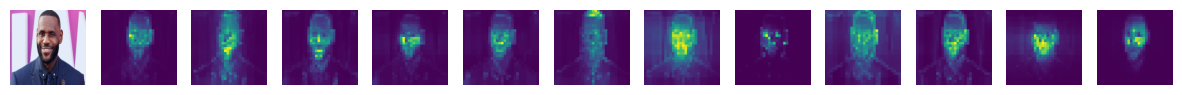

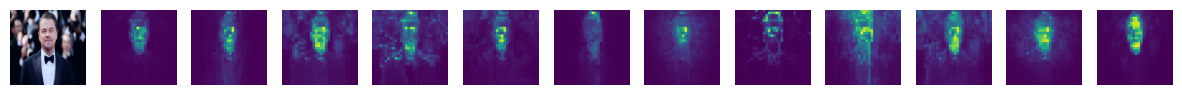

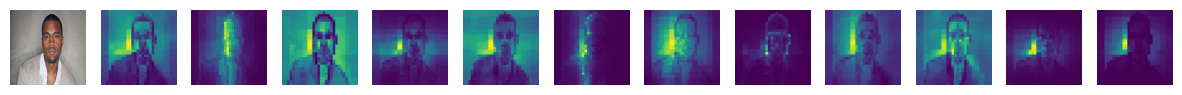

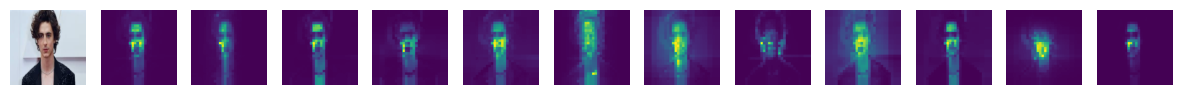

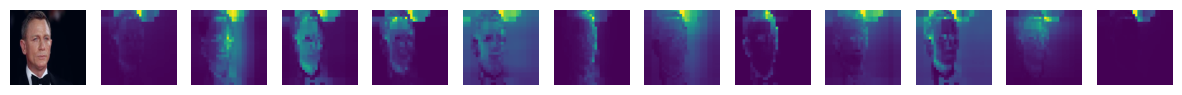

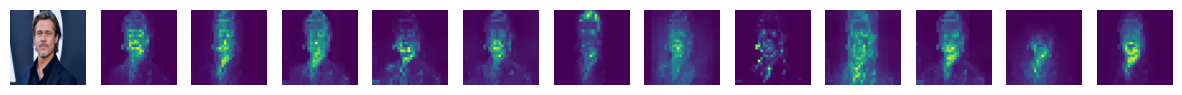

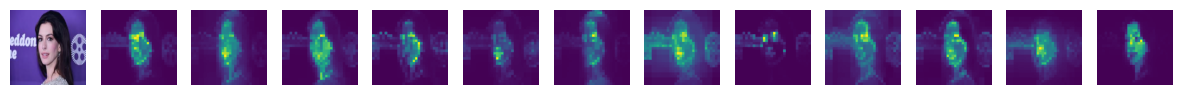

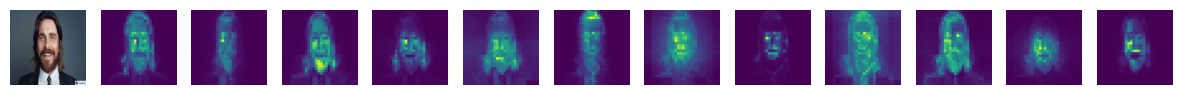

In [11]:
attentions_list, imgs = collect_attention_maps(img_dir, image_size, patch_size, layer, mode)
for i, img in enumerate(imgs):
  attentions = attentions_list[i]
  nh = attentions.shape[0]
  plt.figure(figsize=(15, 3))
  plt.subplot(1, nh + 1,1)
  plt.imshow(img)
  plt.axis('off')
  for j in range(nh):
    plt.subplot(1, nh + 1, j + 2)
    plt.imshow(attentions[j])
    plt.axis('off')

## Visualizing reconstruction
In this section, we visualize the **reconstruction** from a **CRATE auto-encoder**.

In [12]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image


# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.5)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

MAE with pixel reconstruction:


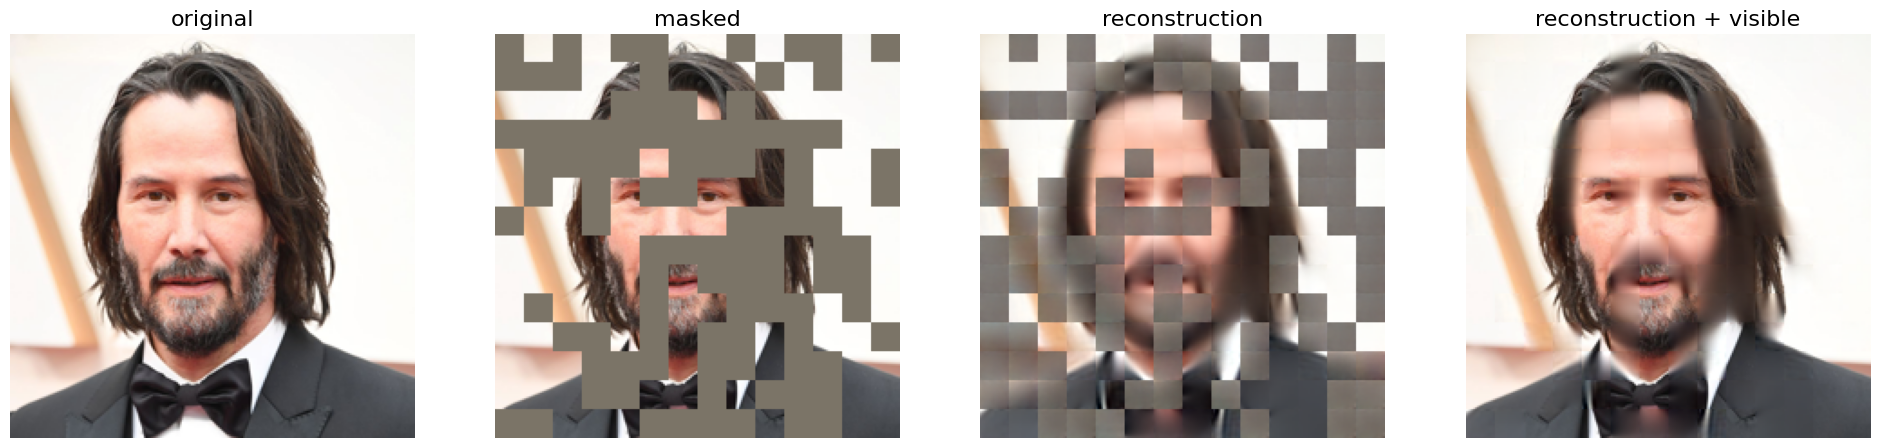

In [13]:
# load an image
img_url = 'https://hips.hearstapps.com/hmg-prod/images/keanu-reeves-arrives-at-the-92nd-annual-academy-awards-at-news-photo-1621623839.?crop=1xw:0.71541xh;center,top&resize=980:*' # fox, from ILSVRC2012_val_00046145
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]

torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model.to('cpu'))


# PCA Visualization



In [14]:
import argparse
import PIL.Image
import numpy
import torch
from pathlib import Path
from vis_utils.shared_extractor import CRATEExtractor
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from typing import List, Tuple
from scipy import ndimage
from vis_utils.pca_visualization import pca, plot_pca, plot_pca_mask
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [15]:
pca_samples = ['birds', 'bus', 'fish', 'cats', 'wolves', 'cows', 'giraffes', 'plane', 'bears', ]
root_dirs = [f'./pca_source/{pca_sample}/' for pca_sample in pca_samples]
save_dirs = [f'./pca_out/{pca_sample}/' for pca_sample in pca_samples]
load_size = 960
facet = 'key'
bin = 'False'
thresholds = [0.5, 0.6, 0.5, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5] # These values decide the thresholds of the background masks. You may adjust it by your self, usually 0.4-0.6 would be nice
invs = [False if i not in [7,8] else True for i in range(len(thresholds))] # For normal cases, set the inv be False to maintain values > threshold; inv set to be True means maintain values < threshold, which works for cases that filters out the foreground objects
last_components_rgb = 'True'
save_resized = 'True'
all_together = 'True'
stride = 16
layer = 10 # It decides which layer to visualize.

In [16]:
all_images = []
for i, root_dir in enumerate(root_dirs):
  with torch.no_grad():
    root_dir = Path(root_dir)
    threshold = thresholds[i]
    images_paths = [x for x in root_dir.iterdir() if x.suffix.lower() in ['.jpg', '.png', '.jpeg']]
    masks = []
    first_components = pca(images_paths, load_size, layer, facet, bin, stride, model_type, model, 1, all_together)
    for image_path, (pil_image, pca_image) in tqdm(zip(images_paths, first_components)):
      mask = plot_pca_mask(pil_image, pca_image, save_resized, th=threshold, inv = invs[i])
      masks.append(mask)
    fg_components = pca(images_paths, load_size,layer, facet, bin, stride, model_type, model, 3, all_together, masks = masks)
    for image_path, (pil_image, pca_image) in tqdm(zip(images_paths, fg_components)):
      og_img, pca_imgs = plot_pca(pil_image, pca_image, last_components_rgb, save_resized)
      all_images.append([og_img] + [pca_imgs[-1]])

4it [00:00, 493.90it/s]
4it [00:00, 87.46it/s]
3it [00:00, 124.71it/s]
3it [00:00, 96.00it/s]
4it [00:00, 182.64it/s]
4it [00:00, 66.75it/s]
5it [00:00, 726.01it/s]
5it [00:00, 98.56it/s]
3it [00:00, 681.82it/s]
3it [00:00, 191.02it/s]
3it [00:00, 671.48it/s]
3it [00:00, 85.17it/s]
4it [00:00, 320.53it/s]
4it [00:00, 62.45it/s]
5it [00:00, 253.73it/s]
5it [00:00, 107.49it/s]
4it [00:00, 636.73it/s]
4it [00:00, 90.78it/s]


<ipython-input-17-14d8efce183e>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 3))


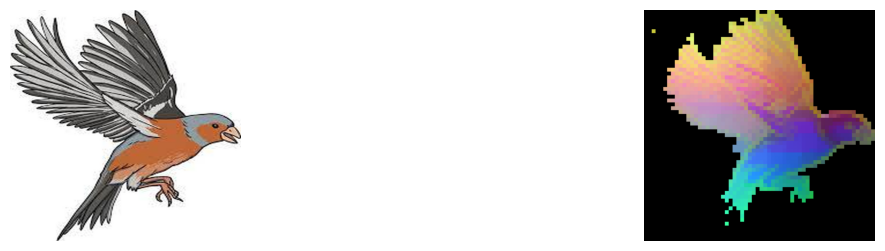

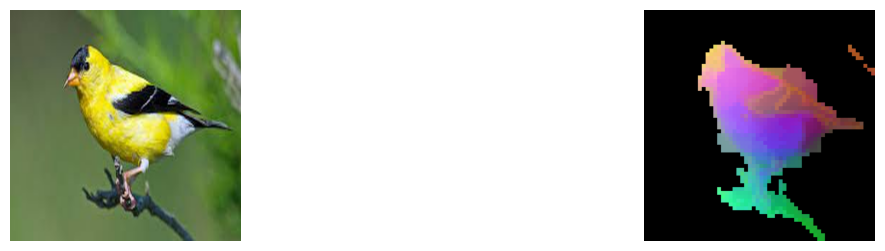

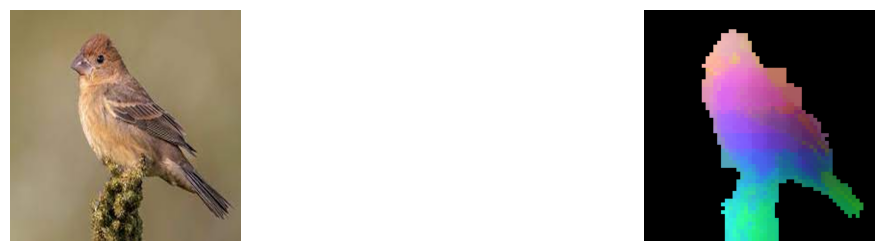

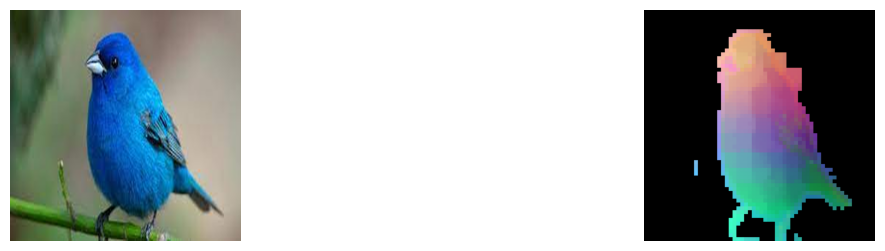

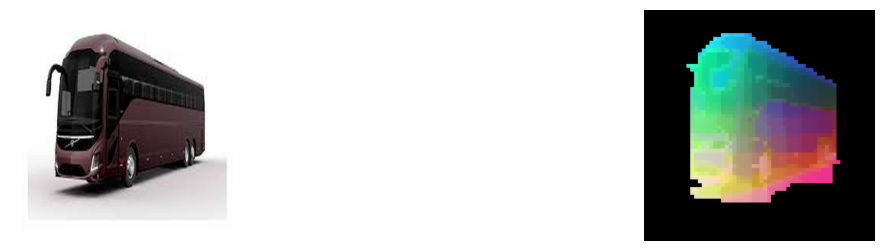

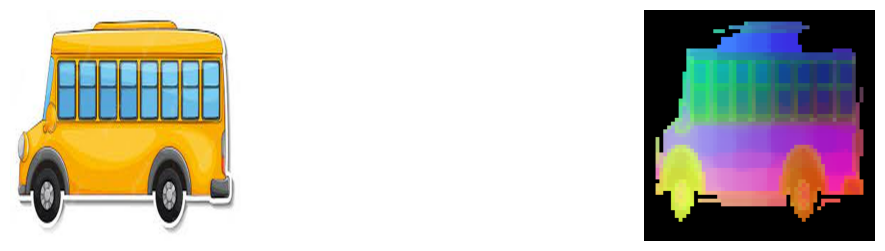

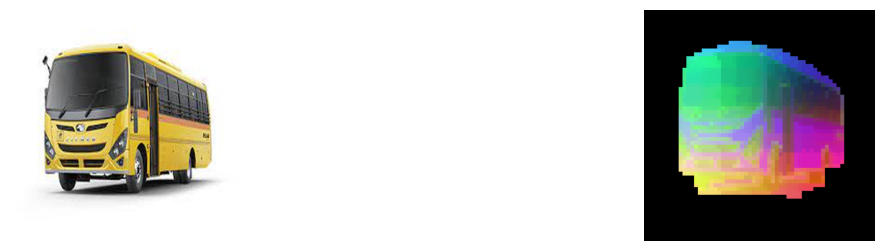

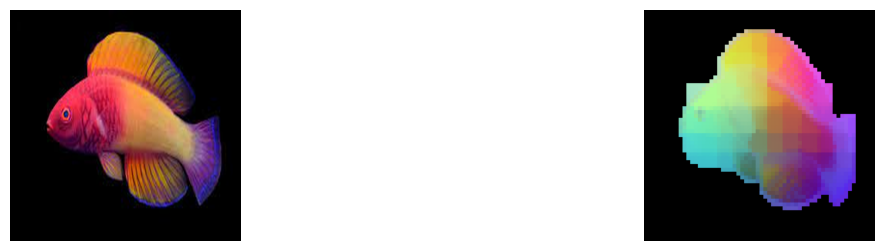

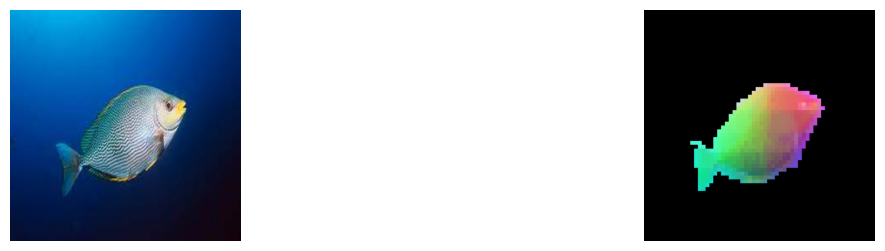

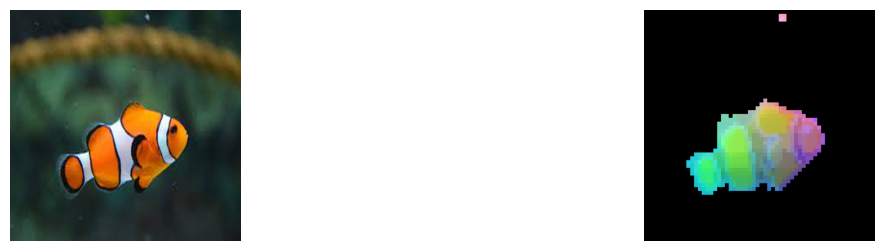

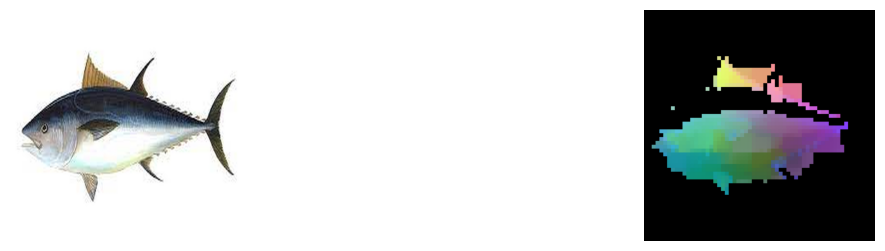

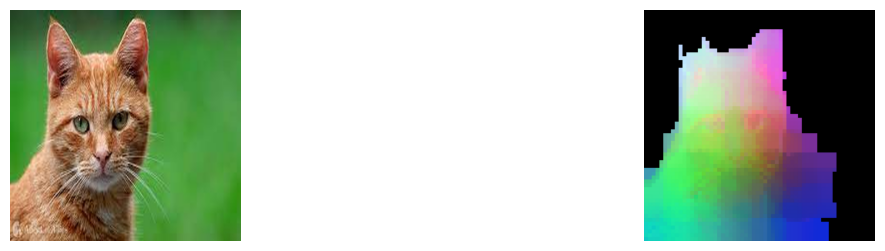

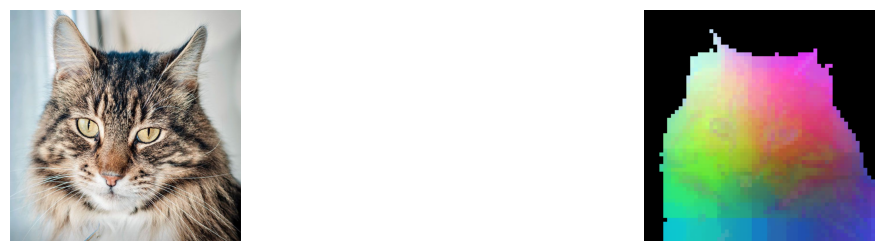

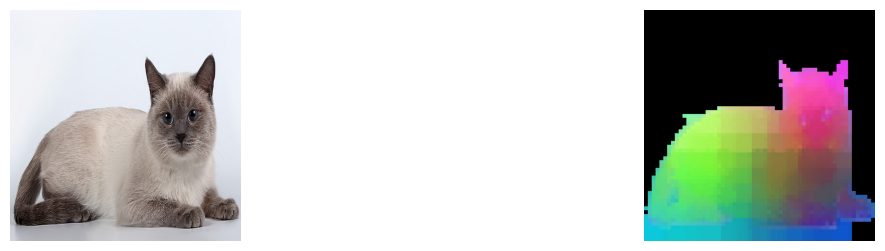

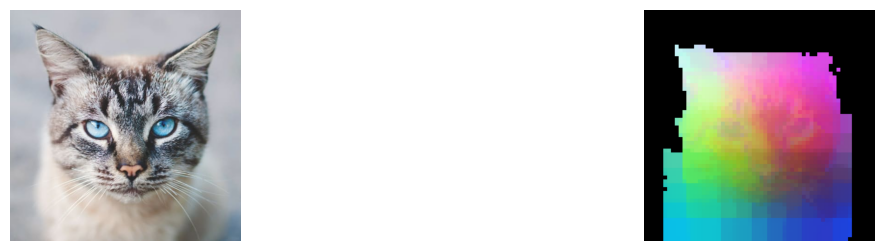

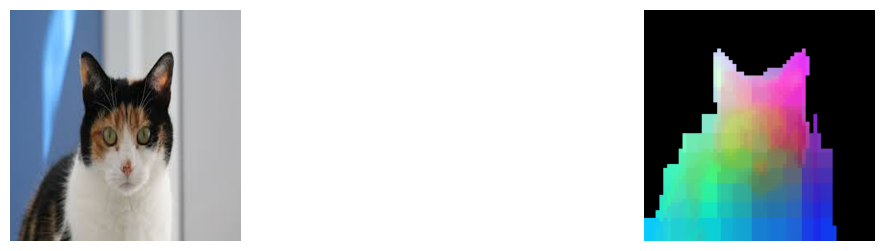

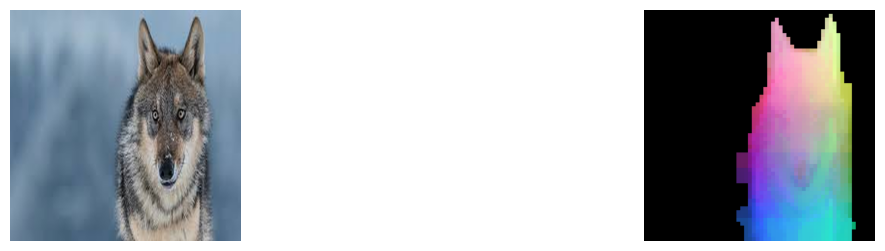

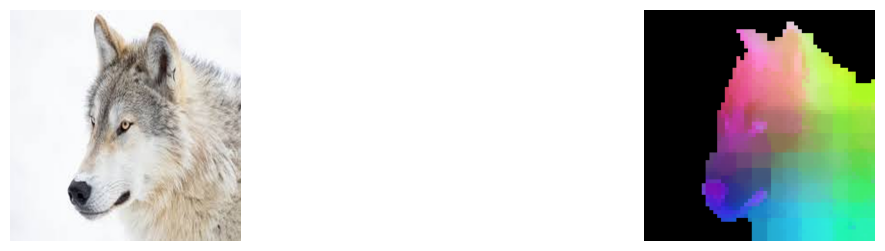

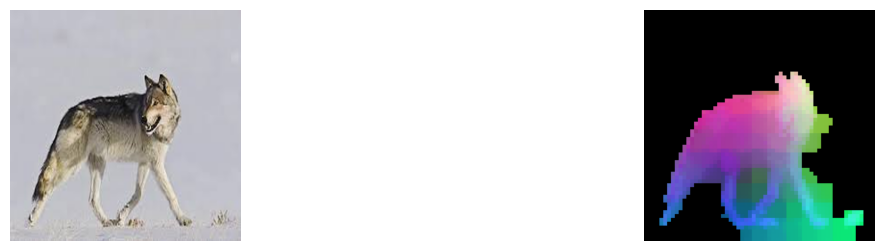

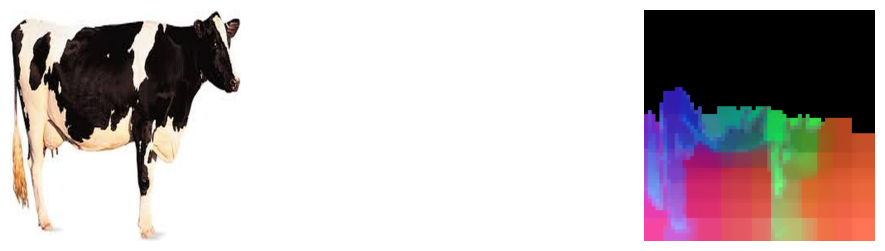

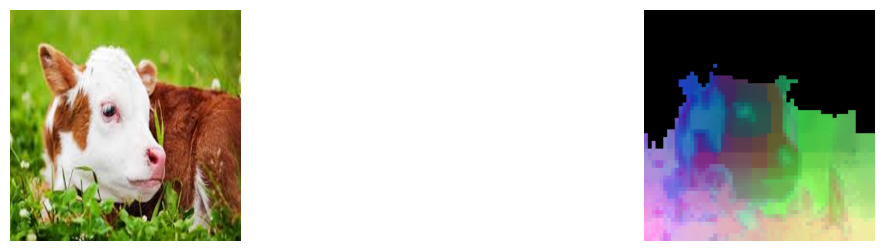

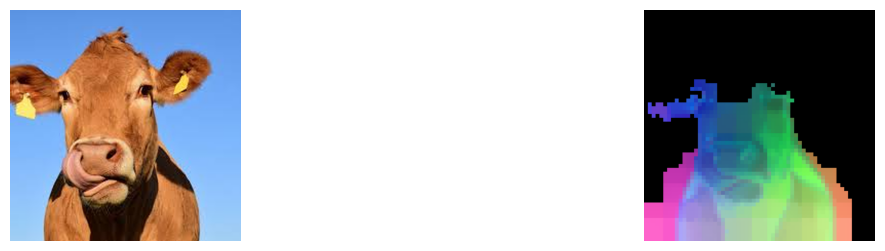

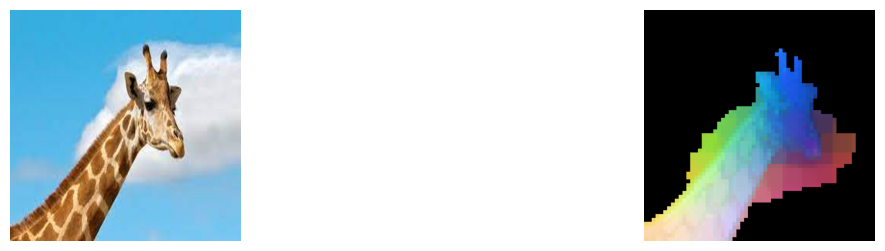

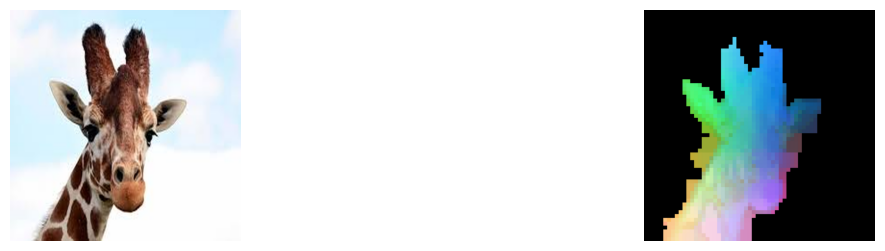

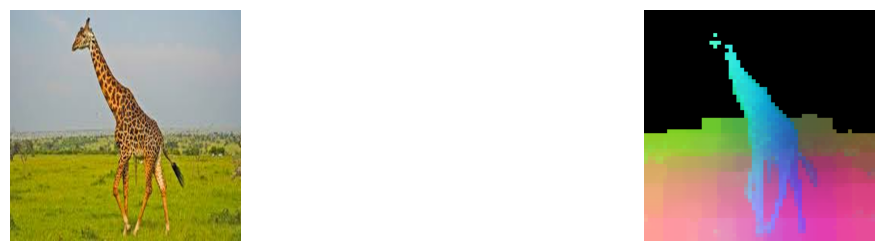

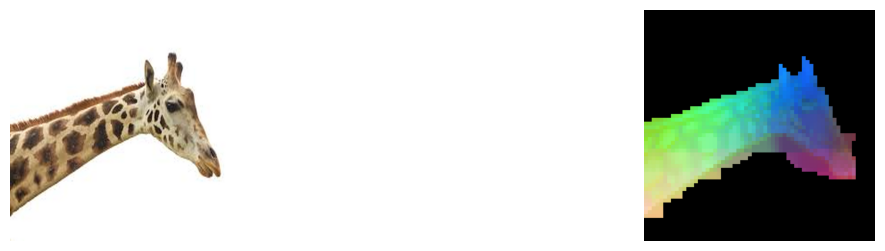

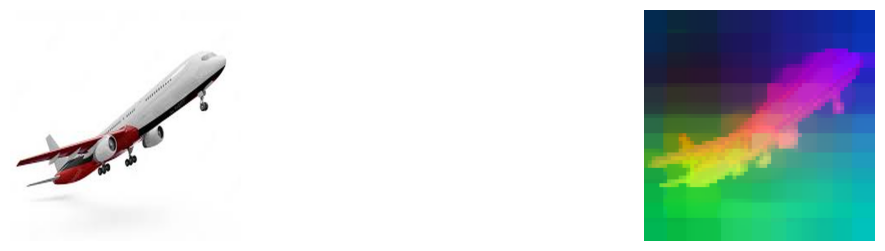

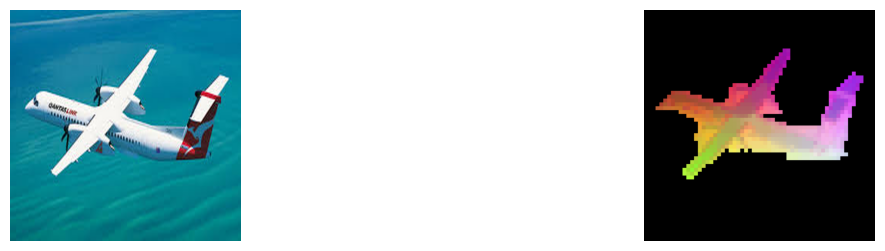

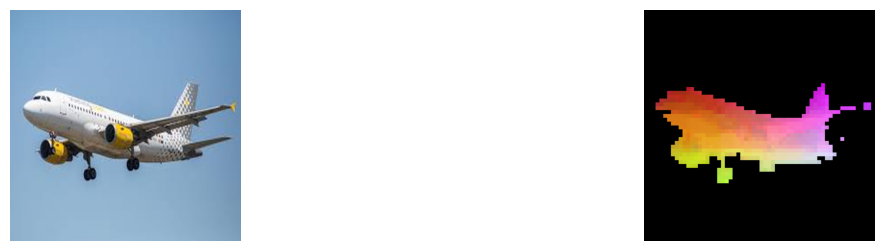

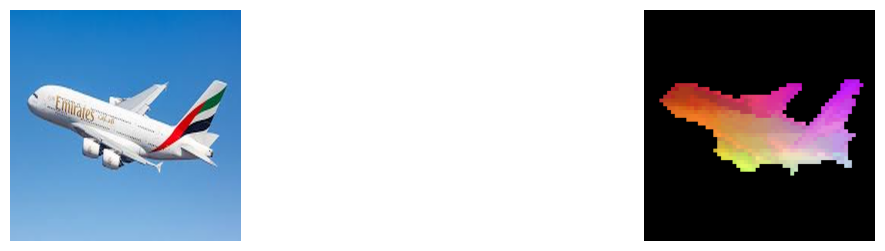

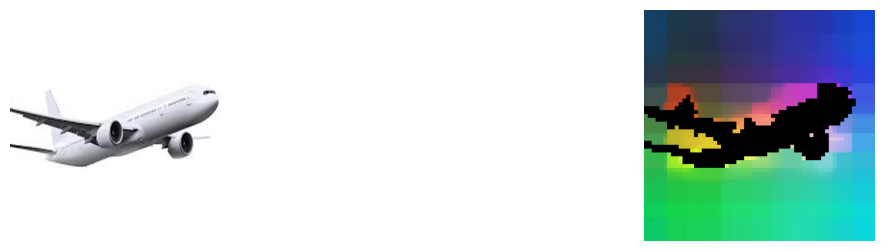

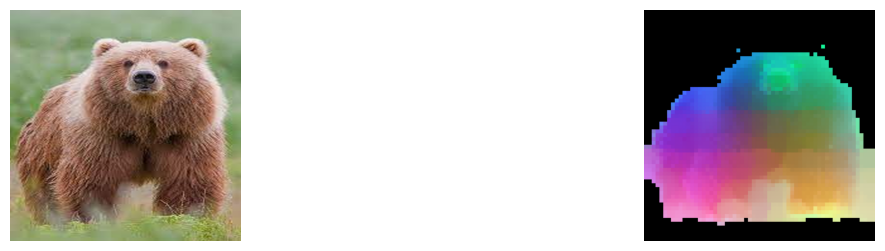

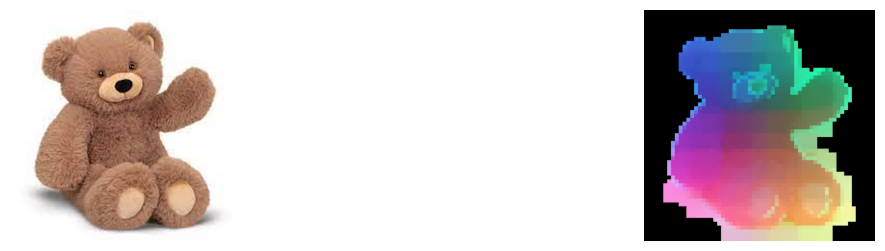

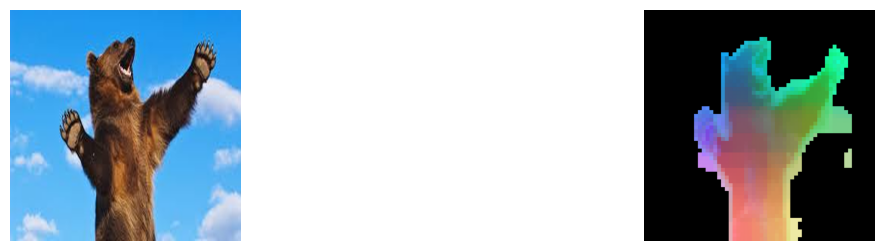

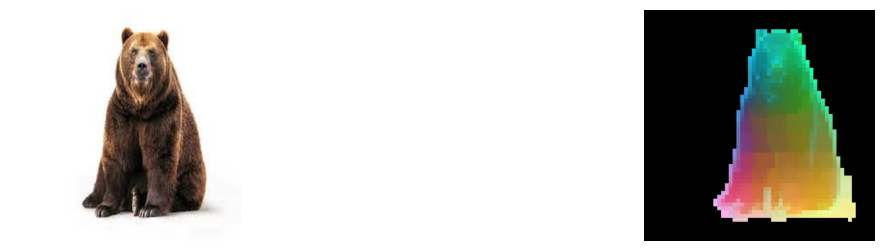

In [17]:
os.makedirs('./pca_out', exist_ok=True)
save_dirs = [f'./pca_out/{pca_sample}/' for pca_sample in pca_samples]

for img_list in all_images:
  plt.figure(figsize=(15, 3))
  for i, img in enumerate(img_list):
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.axis('off')
    # plt.savefig(f'./pca_out/pca_img_{i}_{img}.pdf', format='pdf', bbox_inches='tight')
    # plt.close()